In [16]:
import pymongo
import pickle
import redis
import matplotlib.pyplot as plt
%matplotlib inline
import wikipedia
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import pprint
pp = pprint.PrettyPrinter(indent=1)

rcparams = {'legend.fontsize': 'large',
          'figure.figsize': (10,8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.labelweight' : 'bold',
         'axes.titleweight' : 'bold'}
plt.rcParams.update(params)


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from wikipedia_helper import *

## Downloading articles

In [3]:
mgclient = pymongo.MongoClient('54.202.56.110')
wikipedia_db = mgclient.database_names()
mlbi_collector = mgclient.wikipedia_db.mlbi_collector
if mgclient.wikipedia_db.ml_bi_collector.count() != 0:
    mgclient.wikipedia_db.drop_collection(mlbi_collector)
    test_collector = mgclient.wikipedia_db.mlbi_collector

wiki_categories = [line.rstrip('\n') for line in open('mlbi_categories.txt')]
wiki_categories = [line.split(':')[2] for line in wiki_categories]

pageid_title_df, subcat_dict, uncollected_articles = get_article_category_pageid_titles(wiki_categories,mlbi_collector,append_subcats=True)

r = redis.StrictRedis('54.202.56.110')
subcat_dict = pickle.dumps(subcat_dict)
pageid_title_df = pickle.dumps(pageid_title_df)
uncollected_articles = pickle.dumps(uncollected_articles)
r.set('mlbi_subcat_dict',subcat_dict)
r.set('mlbi_pageid_title_df',pageid_title_df)
r.set('mlbi_uncollected_articles',uncollected_articles)

100%|██████████████████████████████████████████████████████████████████████████████| 1082/1082 [29:12<00:00,  1.73s/it]


number of articles found: 1082
number of articles stored: 1077 




100%|██████████████████████████████████████████████████████████████████████████████| 1243/1243 [32:27<00:00,  1.53s/it]


number of articles found: 1243
number of articles stored: 2312 

Machine_learning has 1082 articles.
Business_intelligence has 1243 articles.
The total number of unique articles found is 2325.
The total number of articles stored is 2312.


True

## Training a model

In [4]:
print("\nRetrieving article texts...")

curs_test = mgclient.wikipedia_db.mlbi_collector.find()

article_contents_df = get_clean_mongo_dataframe(load_wiki_docs(curs_test,mgclient.wikipedia_db.mlbi_collector.count()))

pipe = Pipeline([('tfidf',TfidfVectorizer(stop_words = 'english')),
               ('svd', TruncatedSVD(random_state=12)),
               ('knn', KNeighborsClassifier())])

params = {
            'tfidf__min_df' : [1,2,3],
            'svd__n_components' : [10,50,100],
            'knn__n_neighbors' : range(3,20,2)
}

print("\nFitting the model now...")

gs_pipe = GridSearchCV(pipe, param_grid=params,cv=StratifiedShuffleSplit(random_state=12))
gs_pipe.fit(article_contents_df['clean_text'],article_contents_df['category'])

r = redis.StrictRedis('54.202.56.110')
all_models = pickle.dumps(gs_pipe)
best_models = pickle.dumps(gs_pipe.best_estimator_)
lsa_vectorizer = pickle.dumps(gs_pipe.best_estimator_.steps[0][1])
fit_svd = pickle.dumps(gs_pipe.best_estimator_.steps[1][1])
knn_model = pickle.dumps(gs_pipe.best_estimator_.steps[2][1])
article_df = pickle.dumps(article_contents_df)
r.set('mlbi_all_models',all_models)
r.set('mlbi_best_model',best_models)
r.set('mlbi_vectorizer',lsa_vectorizer)
r.set('mlbi_fit_svd',fit_svd)
r.set('mlbi_knn_model',knn_model)
r.set('mlbi_article_data_df',article_df)

print("\nThe model is ready to make predictions!")


Retrieving article texts...


100%|██████████████████████████████████████████████████████████████████████████████| 2312/2312 [05:16<00:00,  7.30it/s]



Fitting the model now...

The model is ready to make predictions!


In [5]:
gs_pipe_df = pd.DataFrame(gs_pipe.cv_results_)
gs_pipe_df.sort_values('rank_test_score').T

,14,22,32,23,67,13,59,77,31,76,...,61,15,42,79,51,60,7,70,69,78
mean_fit_time,2.713,2.76929,2.90813,2.63299,2.76629,2.85069,2.81146,2.8022,3.12071,2.94009,...,3.58731,4.62902,4.71152,3.72803,4.67651,4.65019,3.56747,3.474,4.54329,4.80566
mean_score_time,0.264983,0.264004,0.297168,0.260304,0.267403,0.269085,0.286674,0.279998,0.301301,0.299834,...,0.348101,0.345567,0.360548,0.355088,0.35384,0.347412,0.330755,0.330106,0.345115,0.3676
mean_test_score,0.958874,0.958442,0.957143,0.95671,0.95671,0.95671,0.956277,0.956277,0.956277,0.955844,...,0.938528,0.938095,0.937662,0.936797,0.934632,0.934632,0.934632,0.933766,0.932468,0.924675
mean_train_score,0.970319,0.966313,0.963948,0.966844,0.96168,0.969836,0.964044,0.963562,0.964817,0.961873,...,0.954875,0.964141,0.954151,0.951062,0.952172,0.949131,0.971622,0.952944,0.94527,0.942809
param_knn__n_neighbors,5,7,9,7,17,5,15,19,9,19,...,15,5,11,19,13,15,3,17,17,19
param_svd__n_components,50,50,50,50,50,50,50,50,50,50,...,100,100,100,100,100,100,100,100,100,100
param_tfidf__min_df,3,2,3,3,2,2,3,3,2,2,...,2,1,1,2,1,1,2,2,1,1
params,"{'knn__n_neighbors': 5, 'svd__n_components': 5...","{'knn__n_neighbors': 7, 'svd__n_components': 5...","{'knn__n_neighbors': 9, 'svd__n_components': 5...","{'knn__n_neighbors': 7, 'svd__n_components': 5...","{'knn__n_neighbors': 17, 'svd__n_components': ...","{'knn__n_neighbors': 5, 'svd__n_components': 5...","{'knn__n_neighbors': 15, 'svd__n_components': ...","{'knn__n_neighbors': 19, 'svd__n_components': ...","{'knn__n_neighbors': 9, 'svd__n_components': 5...","{'knn__n_neighbors': 19, 'svd__n_components': ...",...,"{'knn__n_neighbors': 15, 'svd__n_components': ...","{'knn__n_neighbors': 5, 'svd__n_components': 1...","{'knn__n_neighbors': 11, 'svd__n_components': ...","{'knn__n_neighbors': 19, 'svd__n_components': ...","{'knn__n_neighbors': 13, 'svd__n_components': ...","{'knn__n_neighbors': 15, 'svd__n_components': ...","{'knn__n_neighbors': 3, 'svd__n_components': 1...","{'knn__n_neighbors': 17, 'svd__n_components': ...","{'knn__n_neighbors': 17, 'svd__n_components': ...","{'knn__n_neighbors': 19, 'svd__n_components': ..."
rank_test_score,1,2,3,4,4,4,7,7,7,10,...,72,73,74,75,76,76,76,79,80,81
split0_test_score,0.952381,0.952381,0.952381,0.961039,0.948052,0.952381,0.952381,0.95671,0.952381,0.952381,...,0.935065,0.926407,0.922078,0.926407,0.930736,0.930736,0.904762,0.917749,0.926407,0.922078


In [6]:
gs_pipe.best_params_

{'knn__n_neighbors': 5, 'svd__n_components': 50, 'tfidf__min_df': 3}

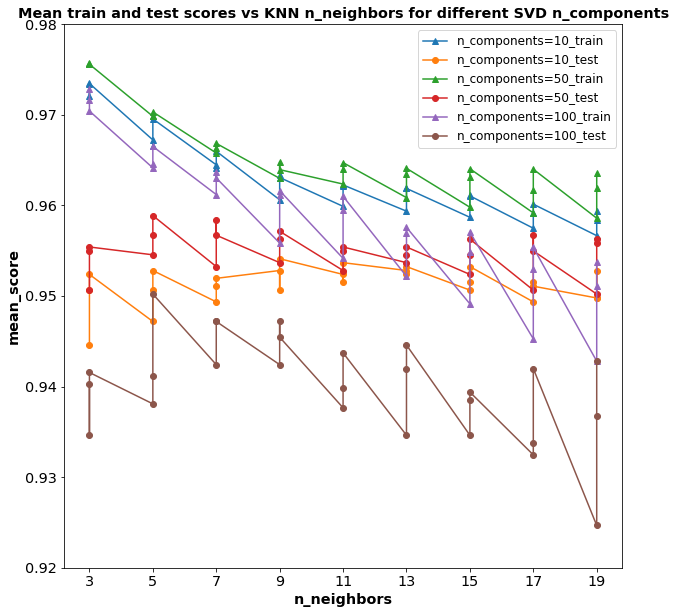

In [23]:
plt.figure(figsize=(10,10))
plt.xticks(range(3,20,2),range(3,20,2))
plt.ylim([0.92,0.98])

for n_comp in params['svd__n_components']:
    plt.plot(gs_pipe_df['param_knn__n_neighbors'][gs_pipe_df['param_svd__n_components'] == n_comp], 
             gs_pipe_df['mean_train_score'][gs_pipe_df['param_svd__n_components'] == n_comp],
             '-^',label='n_components={}_train'.format(n_comp))
    plt.plot(gs_pipe_df['param_knn__n_neighbors'][gs_pipe_df['param_svd__n_components'] == n_comp], 
             gs_pipe_df['mean_test_score'][gs_pipe_df['param_svd__n_components'] == n_comp],
             '-o',label='n_components={}_test'.format(n_comp))
    plt.xlabel('n_neighbors')
    plt.ylabel('mean_score')
    plt.title('Mean train and test scores vs KNN n_neighbors for different SVD n_components')
    plt.legend()

In [8]:
sum(10*gs_pipe_df['mean_fit_time']+10*gs_pipe_df['mean_score_time'])/60

45.478900416692099

## Performing predictions on uncollected articles with the trained model

In [11]:
uncollected_articles_dict = pickle.loads(r.get('mlbi_uncollected_articles'))
lsa_vectorizer = pickle.loads(r.get('mlbi_vectorizer'))
fit_svd = pickle.loads(r.get('mlbi_fit_svd'))
knn_model = pickle.loads(r.get('mlbi_knn_model'))
pageid_title_df = pickle.loads(r.get('mlbi_pageid_title_df'))

new_article_ids = []
for val in uncollected_articles_dict.values():
    if len(val) != 0:
        for i in val:
            new_article_ids.append(i)

correct = []
false_pred_ids = {}
            
for artid in new_article_ids:
    article_text = wikipedia.page(pageid=artid).content
    predict_lsa = preprocess_search_text(article_text,lsa_vectorizer,fit_svd)
    title = pageid_title_df['title'][pageid_title_df['pageid'] == int(artid)].values[0]
    actual = pageid_title_df['category'][pageid_title_df['pageid'] == int(artid)].values[0]
    predicted = knn_model.predict(predict_lsa)[0]
    probabilities = knn_model.predict_proba(predict_lsa)
    max_probability = probabilities.max()
    correct.append([actual == predicted][0])
    if [actual == predicted][0] == False:
        false_pred_ids[artid] = [title,actual,predicted,max_probability]
    print("\nPage ID:", artid)
    print('Title:', title)
    print("Actual Category:", actual)
    print("Predicted Category:", predicted)
    print("Confidence Score:", round(max_probability,2))
    print("Correct prediction:", [actual == predicted][0])

print("\nTotal number of predictions:", len(correct))
print("Percent of correct predictions:", sum(correct)/len(correct))


Page ID: 52202762
Title: Niki.ai
Actual Category: Machine_learning
Predicted Category: Business_intelligence
Confidence Score: 1.0
Correct prediction: False

Page ID: 8220913
Title: ADALINE
Actual Category: Machine_learning
Predicted Category: Machine_learning
Confidence Score: 1.0
Correct prediction: True

Page ID: 4231161
Title: ALOPEX
Actual Category: Machine_learning
Predicted Category: Machine_learning
Confidence Score: 1.0
Correct prediction: True

Page ID: 32003319
Title: (1+ε)-approximate nearest neighbor search
Actual Category: Machine_learning
Predicted Category: Machine_learning
Confidence Score: 1.0
Correct prediction: True

Page ID: 41585002
Title: MLPACK (C++ library)
Actual Category: Machine_learning
Predicted Category: Machine_learning
Confidence Score: 1.0
Correct prediction: True

Page ID: 12481396
Title: PROGNOZ
Actual Category: Business_intelligence
Predicted Category: Business_intelligence
Confidence Score: 1.0
Correct prediction: True

Page ID: 33160128
Title: IN

## Performing searches on the same articles and comparing to the above predictions

In [12]:
for i in false_pred_ids.keys():
    search_article_text = wikipedia.page(pageid=i).content

    vectorizer, fitted_svd, lsa = fit_svd_for_lsa(article_contents_df['clean_text'])

    search_lsa = preprocess_search_text(search_article_text,vectorizer,fitted_svd)

    top_five, top_text = five_most_similar_docs(lsa,search_lsa,article_contents_df)

    print("\n\nSearch text:\n")
    print("Title:", false_pred_ids[i][0])
    print("Actual Category:", false_pred_ids[i][1])
    print("Predicted Category:", false_pred_ids[i][2])
    print("Confidence Score:", false_pred_ids[i][3])
    print("Introduction:", search_article_text.split('\n',1)[0])

    print("\n")
    print("The top 5 related articles are the following:\n")
    print(top_five[['category','title']],"\n\n")

    print("The text from the top related article is below:\n")
    print("Title:", top_text[['title']][0],"\n")
    print("Category:", top_text[['category']][0],"\n")
    print("Website: https://en.wikipedia.org/wiki/{}".format(re.sub('\s','_',top_text[['title']][0])),"\n")
    print("Introduction:", top_text[['clean_text']][0].split('\n',1)[0]) 



Search text:

Title: Niki.ai
Actual Category: Machine_learning
Predicted Category: Business_intelligence
Confidence Score: 1.0
Introduction: Niki is an Indian online electronic commerce company headquartered in Bangalore, Karnataka. It was founded in May 2015 by 4 IIT Kharagpur graduates - Sachin Jaiswal, Keshav Prawasi, Shishir Modi and Nitin Babel.


The top 5 related articles are the following:

                   category           title
1140  Business_intelligence  Flok (company)
1947  Business_intelligence            Kiip
148        Machine_learning            Qloo
1970  Business_intelligence         Sinemia
1822  Business_intelligence      SimilarWeb 


The text from the top related article is below:

Title: Flok (company) 

Category: Business_intelligence 

Website: https://en.wikipedia.org/wiki/Flok_(company) 

Introduction: flok (formerly Loyalblocks) is an American tech startup based in New York City that provides marketing solutions such as chatbots/AI, customer loyalty p

In [9]:
gs_pipe_df[gs_pipe_df['param_tfidf__min_df'] == 1][gs_pipe_df['param_svd__n_components'] == 100].sort_values('rank_test_score').T

,24,33,6,15,42,51,60,69,78
mean_fit_time,4.64638,4.88196,4.6397,4.62902,4.71152,4.67651,4.65019,4.54329,4.80566
mean_score_time,0.352874,0.376364,0.345122,0.345567,0.360548,0.35384,0.347412,0.345115,0.3676
mean_test_score,0.942424,0.942424,0.94026,0.938095,0.937662,0.934632,0.934632,0.932468,0.924675
mean_train_score,0.961197,0.95584,0.972876,0.964141,0.954151,0.952172,0.949131,0.94527,0.942809
param_knn__n_neighbors,7,9,3,5,11,13,15,17,19
param_svd__n_components,100,100,100,100,100,100,100,100,100
param_tfidf__min_df,1,1,1,1,1,1,1,1,1
params,"{'knn__n_neighbors': 7, 'svd__n_components': 1...","{'knn__n_neighbors': 9, 'svd__n_components': 1...","{'knn__n_neighbors': 3, 'svd__n_components': 1...","{'knn__n_neighbors': 5, 'svd__n_components': 1...","{'knn__n_neighbors': 11, 'svd__n_components': ...","{'knn__n_neighbors': 13, 'svd__n_components': ...","{'knn__n_neighbors': 15, 'svd__n_components': ...","{'knn__n_neighbors': 17, 'svd__n_components': ...","{'knn__n_neighbors': 19, 'svd__n_components': ..."
rank_test_score,63,63,69,73,74,76,76,80,81
split0_test_score,0.926407,0.926407,0.939394,0.926407,0.922078,0.930736,0.930736,0.926407,0.922078
